Test projections with pose normalisation for weak perspective

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
import yaml
import numpy as np
import os
from tqdm import tqdm
from load import load_data

In [2]:
# decleare data parameters
# out 00 -> without bln, 0.004
par_train = {'data_dir'        : '/data/LiftPose3D/capture', # change the path 
            'out_dir'          : '/data/LiftPose3D/capture/out_across_animals',
            'train_session_id' : [1],
            'test_session_id'  : [0],
            'test_cam_id'      : [2]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

In [7]:
train_3d, train_2d, _, test_3d, test_2d, _, cams = load_data(par_train)

Loading data...


/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/vision_3d.py:208: RuntimeWarning: divide by zero encountered in true_divide
  poses = poses / poses[:, [2]]
/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/vision_3d.py:208: RuntimeWarning: invalid value encountered in true_divide
  poses = poses / poses[:, [2]]


OK


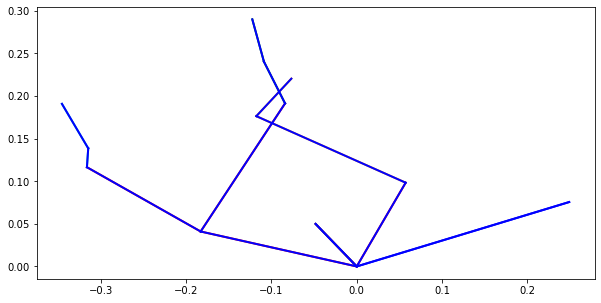

In [12]:
from liftpose.preprocess import anchor_to_root, pose_norm
from liftpose.plot import plot_pose_3d, plot_pose_2d
from liftpose.vision_3d import world_to_camera, project_to_camera
import matplotlib.pyplot as plt

ptssh = train_2d[30,:,:]
pts3d_proj = train_3d[30,:,:]

fig = plt.figure(figsize=(10,5))
ax_2d = fig.add_subplot(111)

target_sets = par_data['data']['target_sets']
roots = par_data['data']['roots']

pts3d_proj = world_to_camera(pts3d_proj[None,:], cams['R'][0], cams['tvec'][0] )
pts3d_proj = project_to_camera(pts3d_proj,cams['intr'][0])

#anchor
pts3d_proj = {'pts3d_proj': pts3d_proj.flatten()[None,:]}
ptssh = {'ptssh': ptssh.flatten()[None,:]}

ptssh, _ = anchor_to_root(ptssh, roots, target_sets, 2)
pts3d_proj, _ = anchor_to_root(pts3d_proj, roots, target_sets, 2)

pts3d_proj = pose_norm(pts3d_proj)
ptssh = pose_norm(ptssh)

pts3d_proj = pts3d_proj['pts3d_proj']
ptssh = ptssh['ptssh']

pts3d_proj = pts3d_proj.reshape(pts3d_proj.size//2,2)
ptssh = ptssh.reshape(ptssh.size//2,2)

plot_pose_2d(ax_2d, ptssh, normalize=False, bones=par_data["vis"]["bones"], limb_id=par_data["vis"]["limb_id"], colors=par_data["vis"]["colors"])
plot_pose_2d(ax_2d, pts3d_proj, normalize=False, bones=par_data["vis"]["bones"], limb_id=par_data["vis"]["limb_id"])

In [8]:
bone_length = {(0, 3): 80.98554459477106,
                 (3, 5): 112.90207543313412,
                 (5, 8): 28.733636975647393,
                 (5, 9): 34.84953102842617,
                 (10, 11): 15.956945352305892,
                 (3, 12): 29.946991312076776,
                 (3, 13): 19.409450872458986,
                 (10, 12): 40.857306953944935,
                 (13, 14): 37.08634981412786,
                 (14, 15): 20.954239695086592,
                 (8, 17): 35.39218881579121,
                 (9, 16): 25.59466626887338,
                 (17, 18): 31.033650232299784,
                 (16, 19): 25.244471236727712}

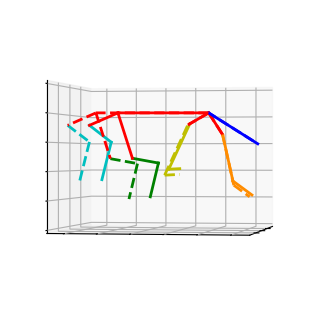

In [16]:
from liftpose.plot import plot_pose_3d
from liftpose.vision_3d import normalize_bone_length
fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=-0, azim=10)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_zlim([0, 100])
t = 15
pose = test_3d[t][None,:,:]

pred = normalize_bone_length(pose.copy(), 
                             root=par["roots"][0], 
                             child=par_data["vis"]["child"], 
                             bone_length=bone_length, 
                             thr=1)
plot_pose_3d(ax=ax, 
             tar=pose[0],
             pred = pred[0],
             normalize=False, 
             bones=par_data["vis"]["bones"], 
             limb_id=par_data["vis"]["limb_id"], 
             colors=par_data["vis"]["colors"])

#plt.savefig('pose_augment.svg')